In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
heat_df = pd.read_csv('data/utilities.csv', usecols = ['temp','ccf'])

heat_df = heat_df.loc[~(((heat_df['temp'] == 60) & (heat_df['ccf']==129)) | 
                        ((heat_df['temp'] == 41) & (heat_df['ccf']==16))), :]

# Cross-Validation

We can use the train-test paradigm to help us choose a model. The idea is to further divide the train set into separate parts where we fit the model on one part and evaluate it on another. This approach is called *cross-validation*.  We describe one version, called $k$*-fold cross-validation*. {numref}`Figure %s <CVDiagram>` shows the idea behind this division of the data.

```{figure} figures/CVDiagram.png
---
name: CVDiagram
---

An example of fivefold cross-validation in which the train set is divided into five parts that are used in turn to validate models built on the remainder of the data 
```

Cross-validation can help select the general form of a model. By this we mean the degree of the polynomial, the number of features in the model, or a cutoff for a regularization penalty (covered in the next section). The basic steps behind $k$-fold cross-validation are as follows: 

1. Divide the train set into $k$ parts of roughly the same size; each part is called a *fold*. Use the same technique that was used to create the train and test sets to make the folds. Typically, we divide the data at random.

2. Set one fold aside to act as a test set:
    + Fit all models on the remainder of the training data (the training data less the particular fold).
    + Use the fold you set aside to evaluate all of these models.
    
3. Repeat this process for a total of $k$ times, where each time you set aside one fold, use the rest of the train set to fit the models, and evaluate them on the fold that was set aside.

4. Combine the error in fitting each model across the folds, and choose the model with the smallest error. 

These fitted models will not have identical coefficients across folds. As an example, when we fit a polynomial of, say, degree 3, we average the MSE across the $k$ folds to get an average MSE for the $k$ fitted polynomials of degree 3. We then compare the MSEs and choose the degree of the polynomial with the lowest MSE.  The actual coefficients for the $x$, $x^2$, and $x^3$ terms in the cubic polynomial are not the same in each of the $k$ fits. Once the polynomial degree is selected, we refit the model using all of the training data and evaluate it on the test set. (We haven't used the test set in any of the earlier steps to select the model.)

Typically, we use 5 or 10 folds.  Another popular choice puts one observation in each fold. This special case is called *leave-one-out cross-validation*. It's popularity stems from the simplicity in adjusting a least squares fit to have one fewer observation. 

Generally, $k$-fold cross-validation takes some computation time since we typically have to refit each model from scratch for each fold. The `scikit-learn` library provides a convenient [`sklearn.model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class to implement $k$-fold cross-validation.

To give you an idea of how k-fold cross-validation works, we'll  demonstrate the technique on the gas consumption example. However, this time we'll fit a different type of model. In the original scatter plot of the data, it looks like the points fall along two connected line segments. In cold temperatures, the relationship between gas consumption and temperature looks roughly linear with a negative slope of about $-4$ cubic ft/degree, and in warmer months, the relationship appears nearly flat. So, rather than fitting a polynomial, we can fit a bent line to the data. 

Let's start by fitting a line with a bend at 65 degrees. To do this, we create a feature that enables the points with temperatures above 65°F to have a different slope. The model is:

$$
y = \theta_0 + \theta_1x + \theta_2(x-65)^+
$$

Here, $ (~)^+ $ stands for "positive part," so when $ x $ is less than 65 it evaluates to 0, and when $ x $ is 65 or greater it is just $ x-65 $. We create this new feature and add it to the design matrix:

In [3]:
y = heat_df["ccf"]
X = heat_df[["temp"]]
X["temp65p"] = (X["temp"] - 65) * (X["temp"] >= 65)

Then we fit the model with these two features:

In [4]:
bend_index = LinearRegression().fit(X, y)

Let's overlay this fitted "curve" on the scatter plot to see how well it captures the shape of the data:

In [5]:
temp = np.arange(10, 80, 1)
temp65p = (temp - 65) * (temp >= 65)

Xs = pd.DataFrame({"temp": temp, "temp65p": temp65p})
y_hats = bend_index.predict(Xs)

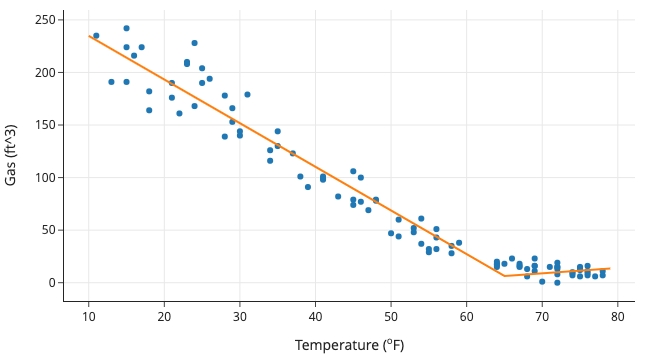

In [7]:
fig = px.scatter(
    heat_df, x="temp", y="ccf",
    labels={"temp": "Temperature (<sup>o</sup>F)", "ccf": "Gas (ft^3)"},
    width=350, height=250
)

fig.add_trace(go.Scatter(x=Xs["temp"], y=y_hats))

fig.update_layout(showlegend=False)
fig.show()

This model appears to fit the data much better than a polynomial. But many bent line models are possible. The line might bend at 55 degrees or 60 degrees, and so on. We can use $k$-fold cross-validation to choose the temperature value at which the line bends. Let's consider models with bends at $ 40, 41, 42, \ldots, 68, 69 $ degrees. For each of these, we need to create the additional feature to enable the line to bend there: 

In [8]:
bends = np.arange(40, 70, 1)

for i in bends:
    col = "temp" + i.astype("str") + "p"
    heat_df[col] = (heat_df["temp"] - i) * (heat_df["temp"] >= i)
heat_df

,temp,ccf,temp40p,temp41p,...,temp66p,temp67p,temp68p,temp69p
0,29,166,0,0,...,0,0,0,0
1,31,179,0,0,...,0,0,0,0
2,15,224,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
96,76,11,36,35,...,10,9,8,7
97,55,32,15,14,...,0,0,0,0
98,39,91,0,0,...,0,0,0,0


The first step in cross-validation is to create our train and test sets. Like before, we choose 22 observations at random to be placed in the test set. That leaves 75 for the train set:

In [9]:
y = heat_df['ccf']
X = heat_df.drop(columns=['ccf'])

test_size = 22

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

Now we can divide the train set into folds. We use three folds so that we have 25 observations in each fold. For each fold, we fit 30 models, one for each bend in the line. For this step, we divide the data with the `KFold` method in `scikit-learn`:

In [10]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

validation_errors = np.zeros((3, 30))


def validate_bend_model(X, y, X_valid, y_valid, bend_index):
    model = LinearRegression().fit(X.iloc[:, [0, bend_index]], y)
    predictions = model.predict(X_valid.iloc[:, [0, bend_index]])
    return mean_squared_error(y_valid, predictions)


for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
    cv_X_train, cv_X_valid = (X_train.iloc[train_idx, :],
                              X_train.iloc[valid_idx, :])
    cv_Y_train, cv_Y_valid = (y_train.iloc[train_idx],
                              y_train.iloc[valid_idx])

    error_bend = [
        validate_bend_model(
            cv_X_train, cv_Y_train, cv_X_valid, cv_Y_valid, bend_index
        )
        for bend_index in range(1, 31)
    ]

    validation_errors[fold][:] = error_bend

Then we find the mean validation error across the three folds and plot them against the location of the bend:

In [11]:
totals = validation_errors.mean(axis=0)

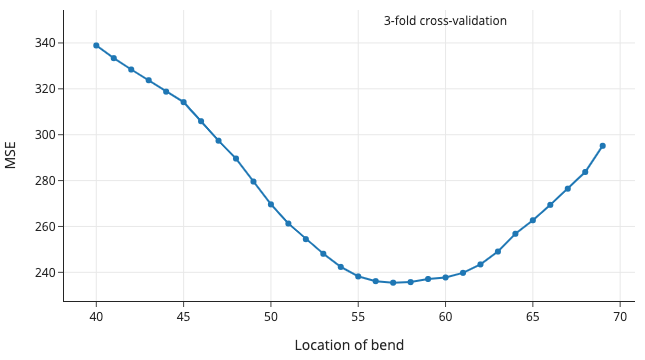

In [12]:
fig = px.line(x=bends, y=totals, markers=True, width=350, height=250)

fig.add_annotation(
    x=60, y=350, text="3-fold cross-validation", showarrow=False
)

fig.update_layout(
    showlegend=False, xaxis_title="Location of bend", yaxis_title="MSE"
)

fig.show()

The MSE looks quite flat for 57 to 60 degrees. The minimum occurs at 58, so we choose that model. To assess this model on the test set, we first fit the bent line model at 58 degrees on the entire train set:

In [15]:
bent_final = LinearRegression().fit(
    X_train.loc[:, ["temp", "temp58p"]], y_train
)

Then we use the fitted model to predict gas consumption for the test set:

In [16]:
y_pred_test = bent_final.predict(X_test.loc[:, ["temp", "temp58p"]])

mean_squared_error(y_test, y_pred_test)

71.40781435952441

Let's overlay the bent-line fit on the scatter plot and examine the residuals to get an idea as to the quality of the fit:

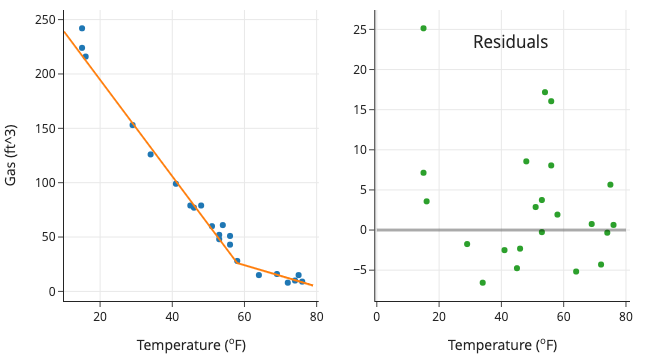

In [17]:
err58 = y_test - y_pred_test

temp = np.arange(10, 80, 1)
temp58p = (temp - 58) * (temp >= 58)

Xs = pd.DataFrame(
    data=np.transpose([temp, temp58p]), columns=["temp", "temp58p"]
)
y_hats = bent_final.predict(Xs)


fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=X_test["temp"], y=y_test, mode="markers"), row=1, col=1
)

fig.add_trace(go.Scatter(x=Xs["temp"], y=y_hats), row=1, col=1)
fig.update_xaxes(title="Temperature (<sup>o</sup>F)", row=1, col=1)
fig.update_yaxes(title="Gas (ft^3)", row=1, col=1)


fig.add_trace(
    go.Scatter(x=X_test["temp"], y=err58, mode="markers"), row=1, col=2
)

fig.add_shape(
    type="line",
    x0=0, y0=0, x1=80, y1=0,
    line=dict(color="Black", width=3),
    row=1, col=2,
)

fig.update_xaxes(title="Temperature (<sup>o</sup>F)", row=1, col=2)

fig.update_layout(
    height=250, width=550,
    showlegend=False,
    title={
        "text": "Residuals",
        "y": 0.9,
        "x": 0.85,
        "xanchor": "right",
        "yanchor": "top",
    },
)

fig.show()

The fitted curve looks reasonable, and the residuals are much smaller than those from the polynomial fit.   

:::{note}

For teaching purposes in this section, we use `KFold` to manually split up the training data into three folds, then find the model validation errors using a loop. In practice, we suggest using `sklearn.model_selection.GridSearchCV` with an `sklearn.pipeline.Pipeline` object, which can automatically break the data into training and validation sets and find the model that has the lowest average validation error across the folds.

:::

Using cross-validation to manage model complexity has a couple of critical limitations: typically it requires the complexity to vary discretely; and there may not be a natural way to order the models. 
Rather than changing the dimensions of a sequence of models, we can fit a large model and apply constraints on the size of the coefficients. This notion is called regularization and is the topic of the next section. 